In [6]:
import sys
import os
import pandas as pd
import scipy
import statsmodels.stats.multitest as smst
from pathlib import Path

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
import utils
import config

save_path = config.save_path
data_path = config.data_path
if not save_path.exists():
    save_path.mkdir()

In [21]:

import pickle 

mice = utils.groupData(dir=data_path, analysis_file_name = "wfstack_3.pkl").mice

def calculateThresholds(percentileResponse, startResponse=44, endResponse=46):
    nStims = percentileResponse.shape[1]
    nAttens = percentileResponse.shape[2]
    threshold = {key: -1 for key in range(nStims)}
    stats_df = pd.DataFrame()
    freqs = []
    attens = []
    pvals = []
    for freq in range(nStims):
        for atten in range(nAttens):
            baseline = percentileResponse[:30,freq,atten].mean(axis=0)
            stimulus = percentileResponse[startResponse:endResponse,freq,atten].mean(axis=0)
            p = scipy.stats.ttest_rel(baseline,stimulus,nan_policy="omit",alternative="less").pvalue
            freqs.append(freq)
            attens.append(atten)
            pvals.append(p)
    
    stats_df = pd.DataFrame({"freq":freqs,"atten":attens,"pvalue":pvals})
    
    #correct for multiple comparisons to control FDR
    hs_correct = smst.multipletests(stats_df["pvalue"], method="fdr_bh", alpha = 0.05)
    stats_df["reject hs"] = list(hs_correct[0])
    stats_df["corrected alpha"] = list(hs_correct[1])

    thresholds = stats_df[stats_df["reject hs"]==True].groupby("freq").max() #get the maximum attenuation the response shows a critical 
    attenmap = {0:90,1:70,2:50,3:30} #remap to human readable values
    thresholds['atten'] = thresholds['atten'].replace(attenmap)
    for i, row in thresholds.iterrows():
        threshold[row.name]=row['atten']
    return threshold

In [23]:
###just do diffence
import pandas as pd
mouse_str = []
geno = []
sex = []
frq= []
thr = []
thr_6mo = []

freqs = [4,8,16,32,64]
for i, mouse in mice[mice.path_6mo!=Path(".")].copy().iterrows():
   mouse.data.calculate_thresholds(p_crit = 0.05)
   threshold = mouse.data.thresholds
   mouse.data_6mo.calculate_thresholds(p_crit = 0.05)
   threshold_6mo = mouse.data_6mo.thresholds
   #threshold = calculateThresholds(mouse.data.percentileResponse, startResponse=44, endResponse=46)
   #threshold_6mo = calculateThresholds(mouse.data_6mo.percentileResponse,startResponse=44, endResponse=46)
   for j, freq in enumerate(freqs):
      mouse_str.append(mouse.Mouse)
      geno.append(mouse.Genotype)
      sex.append(mouse.Sex)
      frq.append(freq)
      thr.append(threshold[j])
      thr_6mo.append(threshold_6mo[j])

df = pd.DataFrame({'mouse':mouse_str,'genotype':geno,'sex':sex,
         'freq':frq,'threshold':thr, "6mo_threshold":thr_6mo})
   
df = df.replace(-1,110)
df = df.replace(0,90)
df = df.replace(20,70)
df = df.replace(40,50)
df = df.replace(60,30)

less_6months = df["6mo_threshold"]<df["threshold"]
print("6 months less than 2 months?")
print(less_6months.value_counts())
df.loc[less_6months, "6mo_threshold"] = df[less_6months]['threshold'] # replace any times where threshold suddenly lower at 6 months, this isn't possible

6 months less than 2 months?
False    103
True       7
Name: count, dtype: int64


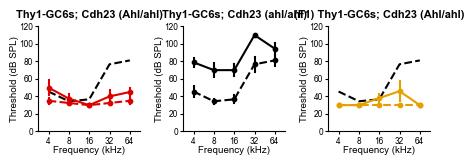

In [25]:
##slight reordering of dataframe
df1 = df.drop(columns="6mo_threshold")
df1['threshold_timepoint'] = "2months"
df2 = df.drop(columns="threshold")
df2 = df2.rename(columns={'6mo_threshold':'threshold'})
df2['threshold_timepoint'] = "6months"
df3 = pd.concat((df1,df2))
df3

color_dict = config.color_dict
order = config.order

import seaborn as sns
import matplotlib.pyplot as plt
import plotting

fig, ax = plt.subplots(1,3, figsize=(4.5,1.75))
for i, geno in enumerate(df3['genotype'].unique()):
    temp = df3[df3['genotype']==geno]
    if geno != 'Thy1-GC6s; Cdh23 (ahl/ahl)':
        temp2 = df3[df3['genotype']=='Thy1-GC6s; Cdh23 (ahl/ahl)']
        sns.pointplot(temp2[temp2['threshold_timepoint']=="2months"], x='freq', y = 'threshold', estimator='mean', errorbar=None, ax= ax[i], color=color_dict['Thy1-GC6s; Cdh23 (ahl/ahl)'], linestyles= '--', linewidth=1.5, markersize=0)
    # sns.pointplot(temp[temp['threshold_timepoint']=="2months"], x='freq', y = 'threshold', estimator = 'mean', errorbar=None, ax= ax[i], color=color_dict[geno], linestyles= '--', linewidth=1.5, markersize=0)
    # sns.pointplot(temp[temp['threshold_timepoint']=="6months"], x='freq', y = 'threshold', estimator = 'mean', errorbar='se', ax= ax[i], color=color_dict[geno], markersize=3, linewidth=1.5)
    sns.pointplot(temp, x='freq', y='threshold', hue = 'threshold_timepoint', ax = ax[i], estimator = 'mean', errorbar= 'se', dodge=00, palette = [color_dict[geno], color_dict[geno]], linestyles=['--','-'], markers=['o','o'], linewidth=1.5, markersize=3)
    ax[i].set_ylim([0,120])
    ax[i].get_legend().remove()
    ax[i].set_xlabel("Frequency (kHz)", labelpad=0, fontsize = 7)
    ax[i].set_ylabel("Threshold (dB SPL)", labelpad=0, fontsize = 7)
    plotting.figQuality(fig, ax[i])
    ax[i].set_title(geno, fontsize=8, fontweight='bold')
    plt.tight_layout()
    
plt.savefig(save_path / "Fig6_CF_thresholds.svg")

In [11]:
# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import numpy as np

models = []
stats = []
genos = []
for geno in df3['genotype'].unique():
    genos.append(geno)
    freqs = []
    temp = df3[df3['genotype'] == geno]
    pvalues = []
    model = ols('threshold ~ C(freq) + C(threshold_timepoint) + C(sex) + C(sex):C(freq):C(threshold_timepoint)', data=temp).fit()
    print(geno, sm.stats.anova_lm(model, typ=2))
    models.append(sm.stats.anova_lm(model, typ=2))
    for freq in temp['freq'].unique():
        mo2 = temp[(temp['threshold_timepoint']=='2months') & (temp['freq']==freq)]['threshold']
        mo6 = temp[(temp['threshold_timepoint']=='6months') & (temp['freq']==freq)]['threshold']
        #print(freq, mo2, mo6)
        freqs.append(freq)
        pval  = scipy.stats.ttest_rel(mo2, mo6).pvalue
        if np.isnan(pval):
            pval = 1
        pvalues.append(pval)

    stats_df = pd.DataFrame({"freqs":freqs, "pval":pvalues})
    mt = multipletests(stats_df['pval'], alpha = 0.05, method="fdr_bh")
    stats_df['reject_hs'] = mt[0]
    stats_df['pval_corrected'] = mt[1]
    stats_df['Genotype']=geno
    stats.append(stats_df)

Thy1-GC6s; Cdh23 (Ahl/ahl)                                              sum_sq    df         F    PR(>F)
C(freq)                                 1480.000000   4.0  2.190789  0.080760
C(threshold_timepoint)                  1125.000000   1.0  6.661184  0.012316
C(sex)                                  1083.000000   1.0  6.412500  0.013967
C(sex):C(freq):C(threshold_timepoint)   1333.666667  13.0  0.607439  0.838442
Residual                               10133.333333  60.0       NaN       NaN
Thy1-GC6s; Cdh23 (ahl/ahl)                                              sum_sq    df          F  \
C(freq)                                27262.222222   4.0  21.666162   
C(threshold_timepoint)                 19951.111111   1.0  63.423151   
C(sex)                                   773.555556   1.0   2.459078   
C(sex):C(freq):C(threshold_timepoint)   4788.666667  13.0   1.170987   
Residual                               22020.000000  70.0        NaN   

                                             

In [12]:
print(genos[0])
models[0]

Thy1-GC6s; Cdh23 (Ahl/ahl)


,sum_sq,df,F,PR(>F)
C(freq),1480.000000,4.0,2.190789,0.080760
C(threshold_timepoint),1125.000000,1.0,6.661184,0.012316
C(sex),1083.000000,1.0,6.412500,0.013967
C(sex):C(freq):C(threshold_timepoint),1333.666667,13.0,0.607439,0.838442
Residual,10133.333333,60.0,NaN,NaN


In [13]:
stats[0]

,freqs,pval,reject_hs,pval_corrected,Genotype
0,4,0.079602,False,0.258879,Thy1-GC6s; Cdh23 (Ahl/ahl)
1,8,0.170471,False,0.284118,Thy1-GC6s; Cdh23 (Ahl/ahl)
2,16,1.000000,False,1.000000,Thy1-GC6s; Cdh23 (Ahl/ahl)
3,32,0.350617,False,0.438271,Thy1-GC6s; Cdh23 (Ahl/ahl)
4,64,0.103552,False,0.258879,Thy1-GC6s; Cdh23 (Ahl/ahl)


In [14]:
print(genos[1])
models[1]

Thy1-GC6s; Cdh23 (ahl/ahl)


,sum_sq,df,F,PR(>F)
C(freq),27262.222222,4.0,21.666162,1.156794e-11
C(threshold_timepoint),19951.111111,1.0,63.423151,2.129339e-11
C(sex),773.555556,1.0,2.459078,1.213571e-01
C(sex):C(freq):C(threshold_timepoint),4788.666667,13.0,1.170987,3.186757e-01
Residual,22020.000000,70.0,NaN,NaN


In [15]:
stats[1]

,freqs,pval,reject_hs,pval_corrected,Genotype
0,4,0.002077,True,0.003462,Thy1-GC6s; Cdh23 (ahl/ahl)
1,8,0.001224,True,0.003462,Thy1-GC6s; Cdh23 (ahl/ahl)
2,16,0.002077,True,0.003462,Thy1-GC6s; Cdh23 (ahl/ahl)
3,32,0.005391,True,0.006739,Thy1-GC6s; Cdh23 (ahl/ahl)
4,64,0.022204,True,0.022204,Thy1-GC6s; Cdh23 (ahl/ahl)


In [16]:
print(genos[2])
models[2]

(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)


,sum_sq,df,F,PR(>F)
C(freq),512.0,4.0,1.476923,0.233921
C(threshold_timepoint),288.0,1.0,3.323077,0.078294
C(sex),12.0,1.0,0.138462,0.712431
C(sex):C(freq):C(threshold_timepoint),1100.0,13.0,0.976331,0.495198
Residual,2600.0,30.0,NaN,NaN


In [19]:
### compare 6 month Ahl+ B6 to ahl B6
freqs = []
temp1 = df3[df3['genotype'] == 'Thy1-GC6s; Cdh23 (Ahl/ahl)']
temp2 = df3[df3['genotype'] == 'Thy1-GC6s; Cdh23 (ahl/ahl)']
pvalues = []

for freq in temp['freq'].unique():
    mo6 = temp1[(temp1['threshold_timepoint']=='6months') & (temp1['freq']==freq)]['threshold']
    mo2 = temp2[(temp2['threshold_timepoint']=='2months') & (temp2['freq']==freq)]['threshold']
    #print(freq, mo2, mo6)
    freqs.append(freq)
    pval  = scipy.stats.ttest_ind(mo2, mo6, alternative='greater').pvalue
    if np.isnan(pval):
        pval = 1
    pvalues.append(pval)

stats_df = pd.DataFrame({"freqs":freqs, "pval":pvalues})
mt = multipletests(stats_df['pval'], alpha = 0.05, method="fdr_bh")
stats_df['reject_hs'] = mt[0]
stats_df['pval_corrected'] = mt[1]
stats_df['Test']='6 month Ahl+ B6 to 2.5 mo ahl B6'
stats.append(stats_df)

stats_df

c:\Users\travisb\miniconda3\envs\suite2p\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,freqs,pval,reject_hs,pval_corrected,Test
0,4,0.660757,False,0.695539,6 month Ahl+ B6 to 2.5 mo ahl B6
1,8,0.695539,False,0.695539,6 month Ahl+ B6 to 2.5 mo ahl B6
2,16,0.101948,False,0.169914,6 month Ahl+ B6 to 2.5 mo ahl B6
3,32,0.003545,True,0.008863,6 month Ahl+ B6 to 2.5 mo ahl B6
4,64,0.000168,True,0.000841,6 month Ahl+ B6 to 2.5 mo ahl B6


In [20]:
### compare 6 month Ahl+ B6.CBA to ahl B6
freqs = []
temp1 = df3[df3['genotype'] == '(F1) Thy1-GC6s; Cdh23 (Ahl/ahl)']
temp2 = df3[df3['genotype'] == 'Thy1-GC6s; Cdh23 (ahl/ahl)']
pvalues = []

for freq in temp['freq'].unique():
    mo6 = temp1[(temp1['threshold_timepoint']=='6months') & (temp1['freq']==freq)]['threshold']
    mo2 = temp2[(temp2['threshold_timepoint']=='2months') & (temp2['freq']==freq)]['threshold']
    #print(freq, mo2, mo6)
    freqs.append(freq)
    pval  = scipy.stats.ttest_ind(mo2, mo6, alternative='greater').pvalue
    if np.isnan(pval):
        pval = 1
    pvalues.append(pval)

stats_df = pd.DataFrame({"freqs":freqs, "pval":pvalues})
mt = multipletests(stats_df['pval'], alpha = 0.05, method="fdr_bh")
stats_df['reject_hs'] = mt[0]
stats_df['pval_corrected'] = mt[1]
stats_df['Test']='6 month Ahl+ B6.CBA to 2.5 mo ahl B6'
stats.append(stats_df)

stats_df

c:\Users\travisb\miniconda3\envs\suite2p\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,freqs,pval,reject_hs,pval_corrected,Test
0,4,0.052159,False,0.086932,6 month Ahl+ B6.CBA to 2.5 mo ahl B6
1,8,0.145086,False,0.181357,6 month Ahl+ B6.CBA to 2.5 mo ahl B6
2,16,0.570524,False,0.570524,6 month Ahl+ B6.CBA to 2.5 mo ahl B6
3,32,0.029390,False,0.073475,6 month Ahl+ B6.CBA to 2.5 mo ahl B6
4,64,0.000018,True,0.000090,6 month Ahl+ B6.CBA to 2.5 mo ahl B6
